In [7]:
import numpy as np
import pandas as pd
import panel as pn
import param
import hvplot.pandas
import holoviews as hv
import hvplot




# Enable Panel extensions
# pn.extension('matplotlib')

class NonHomogeneousPoissonProcess:
    """
    Implementation of Non-homogeneous Poisson Process for neural spike simulation.
    
    Based on the theory from: https://www.randomservices.org/random/poisson/Nonhomogeneous.html
    """
    
    def __init__(self, time_start=-200, time_end=500):
        """
        Initialize the process with time boundaries in milliseconds.
        
        Args:
            time_start: Start time in ms (default: -200)
            time_end: End time in ms (default: 500)
        """
        self.time_start = time_start
        self.time_end = time_end
        
    def rate_function(self, t, lambda_1, lambda_2):
        """
        Define the time-varying rate function λ(t).
        
        Args:
            t: Time array in ms
            lambda_1: Baseline firing rate (spikes/ms)
            lambda_2: Enhanced firing rate (spikes/ms)
            
        Returns:
            Rate function values at times t
        """
        # Ensure t is numpy array for proper indexing
        t = np.asarray(t)
        rate = np.zeros_like(t, dtype=float)
        
        # Baseline period: -200 to 0 ms
        baseline_mask = (t >= -200) & (t < 0)
        rate[baseline_mask] = lambda_1
        
        # Enhanced period: 0 to 200 ms
        enhanced_mask = (t >= 0) & (t < 200)
        rate[enhanced_mask] = lambda_2
        
        # Return to baseline: 200 to 500 ms
        return_mask = (t >= 200) & (t <= 500)
        rate[return_mask] = lambda_1
        
        return rate
    
    def generate_spikes(self, lambda_1, lambda_2, n_trials=1, dt=0.1):
        """
        Generate spike trains using the thinning algorithm for non-homogeneous Poisson processes.
        
        Args:
            lambda_1: Baseline firing rate (spikes/ms)
            lambda_2: Enhanced firing rate (spikes/ms)
            n_trials: Number of spike trains to generate
            dt: Time resolution in ms
            
        Returns:
            List of spike time arrays for each trial
        """
        # Find maximum rate for thinning algorithm
        max_rate = max(lambda_1, lambda_2)
        
        spike_trains = []
        
        for trial in range(n_trials):
            # Generate candidate spike times using homogeneous Poisson with max rate
            total_time = self.time_end - self.time_start
            expected_spikes = int(max_rate * total_time * 2)  # Overestimate
            
            # Generate inter-spike intervals
            intervals = np.random.exponential(1.0 / max_rate, expected_spikes)
            print("Generated intervals:", intervals)
            # Convert to spike times
            candidate_times = np.cumsum(intervals) + self.time_start
            
            # Only keep times within our window
            candidate_times = candidate_times[candidate_times <= self.time_end]
            
            # Apply thinning: accept each spike with probability λ(t)/λ_max
            accepted_spikes = []
            
            for spike_time in candidate_times:
                actual_rate = self.rate_function(np.array([spike_time]), lambda_1, lambda_2)[0]
                accept_prob = actual_rate / max_rate
                
                if np.random.random() < accept_prob:
                    accepted_spikes.append(spike_time)
            
            spike_trains.append(np.array(accepted_spikes))
        
        return spike_trains


class NeuralAnalysisApp(param.Parameterized):
    """
    Panel application for neural population analysis demonstration.
    """
    
    # Parameters that can be controlled by user
    lambda_1 = param.Number(default=0.005, bounds=(0.001, 0.02), step=0.001,
                           doc="Baseline firing rate (spikes/ms)")
    
    lambda_2 = param.Number(default=0.015, bounds=(0.001, 0.05), step=0.001,
                           doc="Enhanced firing rate (spikes/ms)")
    
    n_trials = param.Integer(default=20, bounds=(1, 100), step=1,
                            doc="Number of spike trains to simulate")
    
    def __init__(self, **params):
        super().__init__(**params)
        self.poisson_process = NonHomogeneousPoissonProcess()
        
    def create_plots(self):
        """Create the main visualization plots."""
        
        # Generate spike trains
        spike_trains = self.poisson_process.generate_spikes(
            self.lambda_1, self.lambda_2, self.n_trials
        )
        
        # Create figure with subplots
        fig = Figure(figsize=(12, 8))
        
        # Plot 1: Rate function
        ax1 = fig.add_subplot(3, 1, 1)
        time_axis = np.linspace(-200, 500, 1000)
        rate_values = self.poisson_process.rate_function(time_axis, self.lambda_1, self.lambda_2)
        
        ax1.plot(time_axis, rate_values * 1000, 'b-', linewidth=2, label='Rate λ(t)')
        ax1.axvline(x=0, color='r', linestyle='--', alpha=0.7, label='Stimulus onset')
        ax1.axvline(x=200, color='r', linestyle='--', alpha=0.7, label='Stimulus offset')
        
        # Add colored background regions
        ax1.axvspan(-200, 0, alpha=0.2, color='gray', label='Baseline')
        ax1.axvspan(0, 200, alpha=0.2, color='orange', label='Enhanced')
        ax1.axvspan(200, 500, alpha=0.2, color='gray')
        
        ax1.set_ylabel('Firing Rate\n(spikes/sec)')
        ax1.set_title('Non-homogeneous Poisson Process: Neural Firing Rate')
        ax1.legend(loc='upper right')
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Spike raster
        ax2 = fig.add_subplot(3, 1, 2)
        
        for i, spikes in enumerate(spike_trains):
            if len(spikes) > 0:
                ax2.scatter(spikes, [i] * len(spikes), s=1, c='black', alpha=0.7)
        
        ax2.axvline(x=0, color='r', linestyle='--', alpha=0.7)
        ax2.axvline(x=200, color='r', linestyle='--', alpha=0.7)
        ax2.axvspan(-200, 0, alpha=0.1, color='gray')
        ax2.axvspan(0, 200, alpha=0.1, color='orange')
        ax2.axvspan(200, 500, alpha=0.1, color='gray')
        
        ax2.set_ylabel('Trial Number')
        ax2.set_title(f'Spike Raster Plot ({self.n_trials} trials)')
        ax2.set_ylim(-0.5, self.n_trials - 0.5)
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: PSTH (Peri-Stimulus Time Histogram)
        ax3 = fig.add_subplot(3, 1, 3)
        
        # Combine all spikes
        all_spikes = np.concatenate([spikes for spikes in spike_trains if len(spikes) > 0])
        
        if len(all_spikes) > 0:
            bins = np.linspace(-200, 500, 50)
            counts, bin_edges = np.histogram(all_spikes, bins=bins)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            bin_width = bin_edges[1] - bin_edges[0]
            
            # Convert to firing rate (spikes/sec)
            firing_rate = counts / (self.n_trials * bin_width / 1000)
            
            ax3.bar(bin_centers, firing_rate, width=bin_width*0.8, alpha=0.7, color='navy')
        
        ax3.axvline(x=0, color='r', linestyle='--', alpha=0.7)
        ax3.axvline(x=200, color='r', linestyle='--', alpha=0.7)
        ax3.axvspan(-200, 0, alpha=0.1, color='gray')
        ax3.axvspan(0, 200, alpha=0.1, color='orange')
        ax3.axvspan(200, 500, alpha=0.1, color='gray')
        
        ax3.set_xlabel('Time (ms)')
        ax3.set_ylabel('Firing Rate\n(spikes/sec)')
        ax3.set_title('Peri-Stimulus Time Histogram (PSTH)')
        ax3.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        return fig
    
    def get_stats_text(self):
        """Generate statistics text for display."""
        spike_trains = self.poisson_process.generate_spikes(
            self.lambda_1, self.lambda_2, self.n_trials
        )
        
        # Calculate statistics
        baseline_spikes = []
        enhanced_spikes = []
        return_spikes = []
        
        for spikes in spike_trains:
            baseline_spikes.extend(spikes[(spikes >= -200) & (spikes < 0)])
            enhanced_spikes.extend(spikes[(spikes >= 0) & (spikes < 200)])
            return_spikes.extend(spikes[(spikes >= 200) & (spikes <= 500)])
        
        # Calculate average firing rates
        baseline_rate = len(baseline_spikes) / (self.n_trials * 0.2)  # 200ms period
        enhanced_rate = len(enhanced_spikes) / (self.n_trials * 0.2)  # 200ms period
        return_rate = len(return_spikes) / (self.n_trials * 0.3)     # 300ms period
        
        stats_text = f"""
        **Simulation Statistics:**
        
        **Parameters:**
        - Baseline rate (λ₁): {self.lambda_1:.3f} spikes/ms ({self.lambda_1*1000:.1f} spikes/sec)
        - Enhanced rate (λ₂): {self.lambda_2:.3f} spikes/ms ({self.lambda_2*1000:.1f} spikes/sec)
        - Number of trials: {self.n_trials}
        
        **Observed Rates:**
        - Baseline period (-200 to 0 ms): {baseline_rate:.1f} spikes/sec
        - Enhanced period (0 to 200 ms): {enhanced_rate:.1f} spikes/sec
        - Return period (200 to 500 ms): {return_rate:.1f} spikes/sec
        
        **Analysis:**
        - Fold change: {enhanced_rate/baseline_rate if baseline_rate > 0 else 'N/A'}
        - Total spikes: {sum(len(spikes) for spikes in spike_trains)}
        """
        
        return stats_text


In [12]:
proc = NonHomogeneousPoissonProcess()

lambda_1, lambda_2 = (2 / 1000), (10 / 1000)
# lambda_1, lambda_2 = (2), (10)
proc.rate_function(np.array([-150, 50, 250]), lambda_1, lambda_2)
data = proc.generate_spikes(lambda_1, lambda_2, 1, 1)

data_df = pd.DataFrame(data)
data_df



Generated intervals: [ 76.05472481   5.32146515  41.03836014  14.43493268   6.54722588
 460.12013114  38.91300225 166.00706138  29.38888343 114.4141351
 142.80662228  90.54465942  63.7856644   53.07578135]


,0
0,-56.603291


In [13]:
rng = np.random.default_rng()
time = np.arange(-200, 500, 1)
data = rng.poisson(0.2, time.size)
data.shape
data_df = pd.DataFrame(np.vstack((data, time)).T, columns=['spikes', 'time'])
data_df


,spikes,time
0,0,-200
1,0,-199
2,0,-198
3,1,-197
4,0,-196
...,...,...
695,0,495
696,0,496
697,0,497
698,0,498


In [ ]:
from scipy.stats import expon

expon.cdf(time)

In [10]:
overlay = hv.NdOverlay(
        {
            0: hv.Spikes(
                data_df, kdims='time'
            ).opts(
                # position=i, color=self.DIR_COLORS[self.data.iloc[i]['dir']]
            ) 
        }
    ).opts(
        # yticks=[i for i in np.arange(self.data.shape[0], step=10)],
        # ylabel='Trial #', show_legend=True,
        # title=f"Cell {self.cell_id} Raster Plot aligned to {alignment_point}"
)
overlay.opts(width=800, height=300)

:NdOverlay   [Element]
   :Spikes   [time]   (spikes)

Simulating neuron spikes...
Baseline firing rate: 10 Hz
Stimulus firing rate: 40 Hz
Time periods:
  -200 to 0 ms: Baseline
  0 to 300 ms: Stimulus
  300 to 500 ms: Return to baseline

Simulation Results:
Total time points: 700
Total spikes: 17
Average firing rate: 24.3 Hz

First 10 time points:
   time_ms  spike
0   -200.0      0
1   -199.0      0
2   -198.0      0
3   -197.0      0
4   -196.0      0
5   -195.0      0
6   -194.0      0
7   -193.0      0
8   -192.0      0
9   -191.0      0

Period-specific firing rates:
Baseline 1 (-200 to 0 ms): 10.0 Hz
Stimulus (0 to 300 ms): 50.0 Hz
Baseline 2 (300 to 500 ms): 0.0 Hz


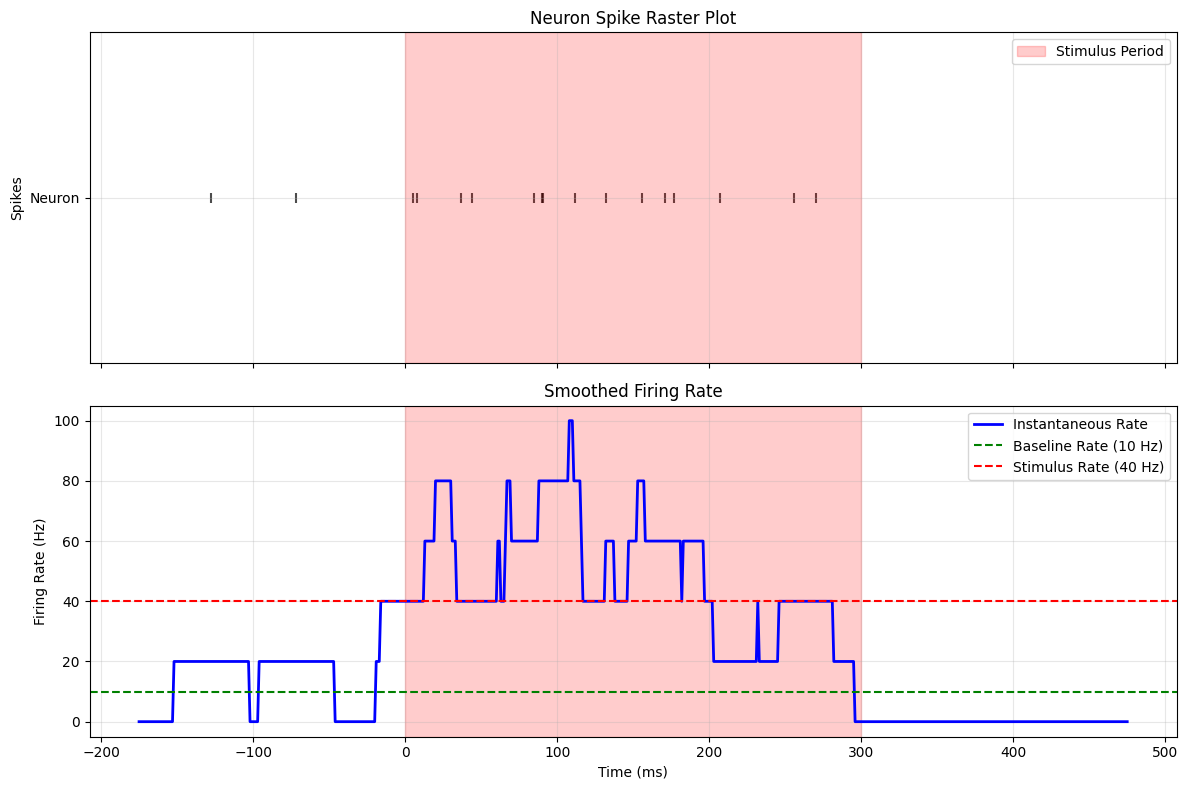


Spike array shape: (700,)
Spike array (first 20 values): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [11]:
import matplotlib.pyplot as plt

def simulate_neuron_spikes(lambda_1, lambda_2, sampling_rate=1000, 
                          baseline_start=-200, stimulus_start=0, 
                          stimulus_end=300, experiment_end=500):
    """
    Simulate neuron spikes using a Poisson process.
    
    Parameters:
    -----------
    lambda_1 : float
        Baseline firing rate (spikes per second)
    lambda_2 : float
        Stimulus-evoked firing rate (spikes per second)
    sampling_rate : int
        Sampling frequency in Hz (default: 1000 Hz = 1 kHz)
    baseline_start : int
        Start time of experiment in ms (default: -200)
    stimulus_start : int
        Start time of stimulus in ms (default: 0)
    stimulus_end : int
        End time of stimulus in ms (default: 300)
    experiment_end : int
        End time of experiment in ms (default: 500)
    
    Returns:
    --------
    pd.DataFrame : DataFrame with time and spike data
    """
    
    # Create time array
    dt = 1000 / sampling_rate  # Time step in milliseconds
    time_points = np.arange(baseline_start, experiment_end, dt)
    n_samples = len(time_points)
    
    # Initialize spike array
    spikes = np.zeros(n_samples, dtype=int)
    
    # Convert firing rates from Hz to probability per time step
    # Probability = rate * dt_in_seconds
    dt_sec = dt / 1000  # Convert dt to seconds
    prob_baseline = lambda_1 * dt_sec
    prob_stimulus = lambda_2 * dt_sec
    
    # Generate random numbers for Poisson process
    random_vals = np.random.uniform(0, 1, n_samples)
    
    # Determine firing rates for each time period
    for i, t in enumerate(time_points):
        if baseline_start <= t < stimulus_start:
            # Baseline period 1
            prob = prob_baseline
        elif stimulus_start <= t < stimulus_end:
            # Stimulus period
            prob = prob_stimulus
        elif stimulus_end <= t < experiment_end:
            # Baseline period 2
            prob = prob_baseline
        else:
            prob = 0
        
        # Generate spike based on Poisson probability
        if random_vals[i] < prob:
            spikes[i] = 1
    
    # Create DataFrame
    df = pd.DataFrame({
        'time_ms': time_points,
        'spike': spikes
    })
    
    return df

def plot_spike_data(df, lambda_1, lambda_2):
    """
    Plot the spike data and firing rate.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # Plot raster (spike times)
    spike_times = df[df['spike'] == 1]['time_ms']
    ax1.scatter(spike_times, np.ones(len(spike_times)), 
                marker='|', s=50, color='black', alpha=0.7)
    ax1.set_ylabel('Spikes')
    ax1.set_ylim(0.5, 1.5)
    ax1.set_yticks([1])
    ax1.set_yticklabels(['Neuron'])
    ax1.set_title('Neuron Spike Raster Plot')
    ax1.grid(True, alpha=0.3)
    
    # Add stimulus period shading
    ax1.axvspan(0, 300, alpha=0.2, color='red', label='Stimulus Period')
    ax1.legend()
    
    # Plot instantaneous firing rate (smoothed)
    window_size = 50  # 50 ms window for smoothing
    spike_rate = df['spike'].rolling(window=window_size, center=True).mean() * 1000
    ax2.plot(df['time_ms'], spike_rate, 'b-', linewidth=2, label='Instantaneous Rate')
    
    # Add expected firing rates as horizontal lines
    ax2.axhline(y=lambda_1, color='green', linestyle='--', 
                label=f'Baseline Rate ({lambda_1} Hz)')
    ax2.axhline(y=lambda_2, color='red', linestyle='--', 
                label=f'Stimulus Rate ({lambda_2} Hz)')
    
    # Add stimulus period shading
    ax2.axvspan(0, 300, alpha=0.2, color='red')
    
    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('Firing Rate (Hz)')
    ax2.set_title('Smoothed Firing Rate')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Example simulation
if __name__ == "__main__":
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Define firing rates
    baseline_rate = 10  # Hz (baseline firing rate)
    stimulus_rate = 40  # Hz (stimulus-evoked firing rate)
    
    # Run simulation
    print("Simulating neuron spikes...")
    print(f"Baseline firing rate: {baseline_rate} Hz")
    print(f"Stimulus firing rate: {stimulus_rate} Hz")
    print("Time periods:")
    print("  -200 to 0 ms: Baseline")
    print("  0 to 300 ms: Stimulus")
    print("  300 to 500 ms: Return to baseline")
    
    spike_data = simulate_neuron_spikes(baseline_rate, stimulus_rate)
    
    # Display basic statistics
    total_spikes = spike_data['spike'].sum()
    total_time_sec = len(spike_data) / 1000
    average_rate = total_spikes / total_time_sec
    
    print(f"\nSimulation Results:")
    print(f"Total time points: {len(spike_data)}")
    print(f"Total spikes: {total_spikes}")
    print(f"Average firing rate: {average_rate:.1f} Hz")
    
    # Show first 10 samples
    print(f"\nFirst 10 time points:")
    print(spike_data.head(10))
    
    # Calculate firing rates for each period
    baseline1 = spike_data[(spike_data['time_ms'] >= -200) & 
                          (spike_data['time_ms'] < 0)]
    stimulus_period = spike_data[(spike_data['time_ms'] >= 0) & 
                                (spike_data['time_ms'] < 300)]
    baseline2 = spike_data[(spike_data['time_ms'] >= 300) & 
                          (spike_data['time_ms'] < 500)]
    
    print(f"\nPeriod-specific firing rates:")
    print(f"Baseline 1 (-200 to 0 ms): {baseline1['spike'].sum() / 0.2:.1f} Hz")
    print(f"Stimulus (0 to 300 ms): {stimulus_period['spike'].sum() / 0.3:.1f} Hz")
    print(f"Baseline 2 (300 to 500 ms): {baseline2['spike'].sum() / 0.2:.1f} Hz")
    
    # Plot the results
    plot_spike_data(spike_data, baseline_rate, stimulus_rate)
    
    # Access the spike array directly (0s and 1s)
    spike_array = spike_data['spike'].values
    print(f"\nSpike array shape: {spike_array.shape}")
    print(f"Spike array (first 20 values): {spike_array[:20]}")

In [28]:
from scipy.io import loadmat

# Load the .mat file
mat_file_path = "data/fiona_sst/trial_names/fi210105a.mat"
mat_data = loadmat(mat_file_path)

# Display the keys in the loaded .mat file
print("Keys in the .mat file:", mat_data.keys())
mat_df = pd.DataFrame({'trial_names': mat_data['trial_names'].T.flatten(), 'file_names': mat_data['file_names'].T.flatten()})
vals = mat_df['trial_names'].value_counts()
vals

Keys in the .mat file: dict_keys(['__header__', '__version__', '__globals__', 'file_names', 'trial_names'])


trial_names
[d270]        89
[d90]         62
[d315]        58
[d45]         53
[d135]        53
[d225]        51
[d180]        47
[d0]          47
[d45v20p]      4
[d90v20a]      3
[d180v20a]     2
[d270v20p]     2
[d270v20a]     2
[d90v20p]      1
[d180v20p]     1
[d225v20a]     1
[d225v20p]     1
[d315v20p]     1
[d315v20a]     1
[d0v20p]       1
[d135v20p]     1
[d135v20a]     1
[d45v20a]      1
[d0v20a]       1
Name: count, dtype: int64

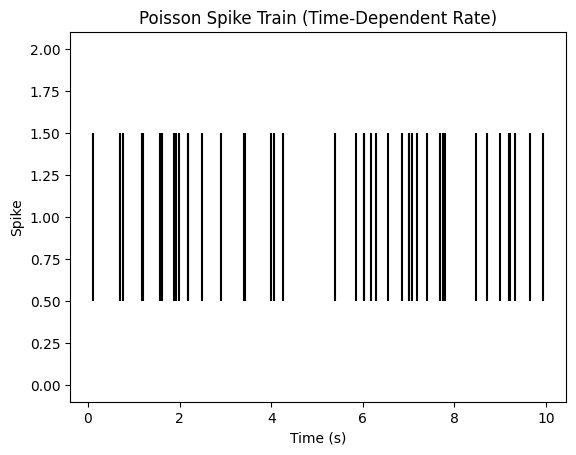

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def generate_inhomogeneous_poisson_spikes(rate_func, T, dt=0.001):
    """
    Generate spike times for a neuron with a time-dependent firing rate using an inhomogeneous Poisson process.
    
    Parameters:
    rate_func (function): Function that gives the firing rate at time t (spikes per second).
    T (float): Total duration of the simulation (seconds).
    dt (float): Time step for simulation (seconds).
    
    Returns:
    spike_times (list): List of spike times.
    """
    spike_times = []
    t = 0
    
    while t < T:
        rate = r(t)
        if rate * dt > np.random.rand():
            spike_times.append(t)
        t += dt
    
    return spike_times

# Example usage
def r(t):
    return 5 + 2 * np.sin(2 * np.pi * t / 5)  # Time-dependent rate function

T = 10  # total duration in seconds
spike_times = generate_inhomogeneous_poisson_spikes(r, T)

# Plotting the spike train
plt.eventplot(spike_times, orientation='horizontal', colors='black')
plt.xlabel('Time (s)')
plt.ylabel('Spike')
plt.title('Poisson Spike Train (Time-Dependent Rate)')
plt.show()